# <center>Cats vs. Dogs - SVM vs. CNN<center>

## Dataset Description:

The data set that I'm using was obtained from Kaggle (https://www.kaggle.com/c/dogs-vs-cats/data). It contains 25,000 labeled images combining to 571.9 MB. Throughout the notebook these images are manipulated several times to turn them into feasible training data for the models.

## 0. Importing Libraries

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import cv2
from itertools import chain
np.random.seed(123)

import scipy
from scipy import misc, ndimage
from random import randint
from skimage.color import rgb2grey
from skimage.feature import hog
import matplotlib as mpl


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

import keras
from keras import backend as K
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPooling2D
from keras.layers.convolutional import *
from keras.utils import np_utils
from keras.metrics import categorical_crossentropy, binary_crossentropy
from keras.callbacks import History
from keras.utils.vis_utils import plot_model


import warnings
warnings.filterwarnings('ignore')

## 1. Image Loading and Preprocessing

### 1.1 Image loading and resizing with optional data augmentation:

In [144]:
# Function to load and resize images with optional data augmentation:

def create_training_data(data_path, img_size, generator=False, aug_size=10):
    
    samples, labels = [], []
    img_paths = os.listdir(data_path)
    counter = 1
    
    for img in img_paths:
        
        if (counter%5000 == 0):
            print("Image " + str(counter) + " of " + str(len(img_paths)) + ".")
        
        # Image loading:
        img_array = cv2.imread(os.path.join(data_path,img))
        
        # Image resizing:
        img_array = cv2.resize(img_array, (img_size,img_size))
        img_array = np.expand_dims(img_array,0)
        
        # Optional data augmentation:
        if isinstance(generator, bool):
            samples.append(img_array)
            labels.append(0 if img[:3]=='cat' else 1)
        else:
            aug_iter = generator.flow(img_array)
            aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(aug_size)]
            samples.append(aug_images)
            labels += aug_size * [0 if img[:3]=='cat' else 1]
            
    
        counter +=1
        
    samples = list(chain(*samples))
    
    return samples, labels

In [145]:
# Calling the create_training_data funciton:

data_path = 'data/train'
img_size = 200

generator = ImageDataGenerator(rotation_range=10, width_shift_range=0.1,
                              height_shift_range=0.1, shear_range=0.15,
                              zoom_range=0.1, channel_shift_range=10,
                              horizontal_flip=True)

samples, labels = create_training_data(data_path, img_size)

Image 5000 of 25000.
Image 10000 of 25000.
Image 15000 of 25000.
Image 20000 of 25000.
Image 25000 of 25000.


In [77]:
# Saving preprocessed data as npy files

np.save('data/samples.npy', samples)
np.save('data/labels.npy', labels)

In [121]:
samples = np.load('data/samples.npy')
labels = np.load('data/labels.npy')

## 2. Statistical Machine Learning Approach:

### 2.1 Building and SVM Model using a Histogram of Oriented Gradients (HOG):

#### Original Image:

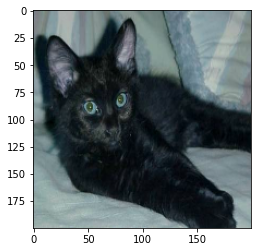

In [188]:
plt.imshow(samples[333])

#### HOG Features:

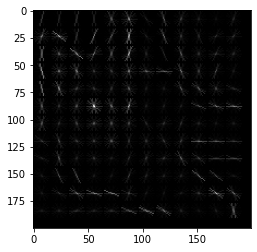

In [189]:
hog_features, hog_image = hog(samples[333],
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))
plt.imshow(hog_image, cmap=mpl.cm.gray)

In [178]:
svm_samples = []
svm_labels = labels
counter = 1
for i in range(len(samples)):
    if (counter%5000 == 0):
            print("Image " + str(counter) + " of " + str(len(samples)) + ".")
    hog_features = hog(samples[i],
                       visualize=True,
                       block_norm='L2-Hys',
                       pixels_per_cell=(16,16))
    svm_samples.append(hog_features[0])
    counter += 1

Image 5000 of 25000.
Image 10000 of 25000.
Image 15000 of 25000.
Image 20000 of 25000.
Image 25000 of 25000.


In [56]:
np.save('data/svm_samples_16x16.npy', svm_samples)

In [179]:
scaler = StandardScaler()
scaled_svm_samples = scaler.fit_transform(svm_samples)
np.save('data/scaled_svm_samples_16x16.npy', scaled_svm_samples)
scaled_svm_samples.shape

(25000, 8100)

In [180]:
# Splitting the images into train and test sets:

train_samples, test_samples, train_labels, test_labels = train_test_split(
                            scaled_svm_samples, svm_labels, test_size=0.2, random_state=42)

In [181]:
svm_model = svm.LinearSVC(verbose=1,random_state=24)

In [182]:
svm_model.fit(train_samples, train_labels)

[LibLinear]

LinearSVC(random_state=24, verbose=1)

In [71]:
pred_labels = svm_model.predict(test_samples)
accuracy = accuracy_score(test_labels, pred_labels)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.6946


In [72]:
import pickle

pkl_filename = "saved_models/svm_model_12x12.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(svm_model, file)

### 2.2 Testing other HOG pixel densities:

In [ ]:
dims = [8,10,12]

for dim in dims:
    print("Hog Dimension: " + dim)
    
    for i in range(len(samples)):
        if (counter%5000 == 0):
                print("Image " + str(counter) + " of " + str(len(samples)) + ".")
        hog_features = hog(samples[i],
                           visualize=True,
                           block_norm='L2-Hys',
                           pixels_per_cell=(dim,dim))
        svm_samples.append(hog_features[0])
        counter += 1
    
    scaler = StandardScaler()
    scaled_svm_samples = scaler.fit_transform(svm_samples)
    
    train_samples, test_samples, train_labels, test_labels = train_test_split(
                        scaled_svm_samples, svm_labels, test_size=0.2, random_state=42)
    
    svm_model = svm.LinearSVC(verbose=1,random_state=24)
    svm_model.fit(train_samples, train_labels)

    pred_labels = svm_model.predict(test_samples)

    accuracy = accuracy_score(test_labels, pred_labels)
    print('Model' + dim + ' accuracy is: ', accuracy)

    pkl_filename = 'saved_models/svm_model_' + str(dim) + 'x' + str(dim) + '.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(svm_model, file)

### 2.3 Incorporating Principal Component Analysis (PCA):

In [80]:
n_pcs = [500, 1000, 2000]
dims = [8,10,12,16]

for n_pc in n_pcs:
    print("Number of PCs: " + str(n_pc))
    for dim in dims:
        print("Hog Dimension: " + dim)
        
        for i in range(len(samples)):
            if (counter%5000 == 0):
                    print("Image " + str(counter) + " of " + str(len(samples)) + ".")
            hog_features = hog(samples[i],
                               visualize=True,
                               block_norm='L2-Hys',
                               pixels_per_cell=(dim,dim))
            svm_samples.append(hog_features[0])
            counter += 1
        
        scaler = StandardScaler()
        scaled_svm_samples = scaler.fit_transform(svm_samples)
        np.save('data/scaled_svm_samples_' + str(dim) + 'x' + str(dim) + '.npy', scaled_svm_samples_)

        pca = PCA(n_components=n_pc)
        pca_samples = pca.fit_transform(scaled_svm_samples)
        
        print("PCA Shape: " + str(pca_samples.shape))
        np.save('data/pca_svm_samples_' + str(dim) + 'x' + str(dim) + '_' + str(n_pc) + '.npy', pca_samples)
        
        train_samples, test_samples, train_labels, test_labels = train_test_split(
                            pca_samples, svm_labels, test_size=0.2, random_state=42)
        
        svm_model = svm.LinearSVC(verbose=1,random_state=24)
        svm_model.fit(train_samples, train_labels)

        pred_labels = svm_model.predict(test_samples)

        accuracy = accuracy_score(test_labels, pred_labels)
        print('Model' + dim + ' accuracy is: ', accuracy)

        pkl_filename = 'saved_models/svm_model_' + str(dim) + 'x' + str(dim) + '_' str(n_pc) + '_pca.pkl'
        with open(pkl_filename, 'wb') as file:
            pickle.dump(svm_model, file)

Number of PCs: 500
Hog Dimension: 8x8
PCA Shape: (25000, 500)
[LibLinear]Model8x8 accuracy is:  0.6462
Hog Dimension: 10x10
PCA Shape: (25000, 500)
[LibLinear]Model10x10 accuracy is:  0.6754
Hog Dimension: 12x12
PCA Shape: (25000, 500)
[LibLinear]Model12x12 accuracy is:  0.6584
Hog Dimension: 14x14
PCA Shape: (25000, 500)
[LibLinear]Model14x14 accuracy is:  0.6588
Hog Dimension: 16x16
PCA Shape: (25000, 500)
[LibLinear]Model16x16 accuracy is:  0.6226
Number of PCs: 2000
Hog Dimension: 8x8
PCA Shape: (25000, 2000)
[LibLinear]Model8x8 accuracy is:  0.6614
Hog Dimension: 10x10
PCA Shape: (25000, 2000)
[LibLinear]Model10x10 accuracy is:  0.677
Hog Dimension: 12x12
PCA Shape: (25000, 2000)
[LibLinear]Model12x12 accuracy is:  0.6552
Hog Dimension: 14x14
PCA Shape: (25000, 2000)
[LibLinear]Model14x14 accuracy is:  0.6872
Hog Dimension: 16x16
PCA Shape: (25000, 2000)
[LibLinear]Model16x16 accuracy is:  0.6786


### 2.4 Accuracy Levels for all SVM Models:

![title](images/svm_acc_table.png)

In the end, the chosen model was the SVM with 16x16 HOG without PCA. It was the best trade-off between training time and accuracy, taking ~12 minutes to generate the feature data set and ~6 minutes to train the SVM model.

## 3. Deep Learning Approach:

### 3.1 16-layer CNN:

#### 3.1.1 Network Structure Diagram:

![title](images/model_plot_long_cnn.png)

In [164]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), input_shape=(200,200,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [165]:
cnn_model.compile(loss='binary_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])

In [169]:
history = cnn_model.fit([samples], [labels], batch_size=32, epochs=20, validation_split=0.2,verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/20
20000/20000 [==============================] - 454s 23ms/step - loss: 8.0047 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 2/20
20000/20000 [==============================] - 432s 22ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 3/20
20000/20000 [==============================] - 426s 21ms/step - loss: 0.6932 - accuracy: 0.4945 - val_loss: 0.6931 - val_accuracy: 0.5034
Epoch 4/20
20000/20000 [==============================] - 418s 21ms/step - loss: 0.6932 - accuracy: 0.4979 - val_loss: 0.6931 - val_accuracy: 0.5034
Epoch 5/20
20000/20000 [==============================] - 408s 20ms/step - loss: 0.6932 - accuracy: 0.5033 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 6/20
20000/20000 [==============================] - 403s 20ms/step - loss: 0.7678 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4966
Epoch 7/20
20000/20000 [==============================] -

In [177]:
cnn_model.save('saved_models/long_cnn_model')

In [176]:
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_51 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 198, 198, 32)      0         
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 97, 97, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 97, 97, 64)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 46, 46, 128)     

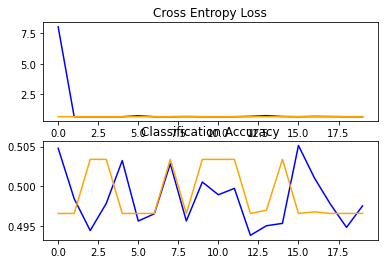

In [171]:
# Plotting the Cross Entropy Loss and the Classification Accuracy throughout th eepochs

plt.subplot(211)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='test')

plt.subplot(212)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='test')

### 3.2 10-layer CNN:

#### 3.2.1 Network Structure Diagram:

![title](images/model_plot_short_cnn.png)

#### 3.2.2 Network Implementation:

In [140]:
cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', kernel_initializer='he_uniform',  padding='same', input_shape=(200,200,3)),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64, (3,3), activation='relu', kernel_initializer='he_uniform',  padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',  padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation='relu', kernel_initializer='he_uniform'),
    Dense(1, activation='sigmoid')
])

In [97]:
cnn.compile(loss='binary_crossentropy', 
            optimizer=Adam(lr=0.0001),
            metrics=['accuracy'])

#### 3.2.3 Network Training:

In [98]:
history = cnn.fit(samples, labels, batch_size=100, epochs=30, validation_split=0.2,verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 471s 24ms/step - loss: 18.7482 - accuracy: 0.5809 - val_loss: 1.0864 - val_accuracy: 0.6368
Epoch 2/30
20000/20000 [==============================] - 432s 22ms/step - loss: 0.9341 - accuracy: 0.6784 - val_loss: 0.8430 - val_accuracy: 0.6992
Epoch 3/30
20000/20000 [==============================] - 412s 21ms/step - loss: 0.7369 - accuracy: 0.7334 - val_loss: 0.7588 - val_accuracy: 0.7164
Epoch 4/30
20000/20000 [==============================] - 419s 21ms/step - loss: 1.0017 - accuracy: 0.7401 - val_loss: 0.7431 - val_accuracy: 0.7202
Epoch 5/30
20000/20000 [==============================] - 384s 19ms/step - loss: 0.4745 - accuracy: 0.8005 - val_loss: 0.7248 - val_accuracy: 0.7276
Epoch 6/30
20000/20000 [==============================] - 402s 20ms/step - loss: 0.3947 - accuracy: 0.8267 - val_loss: 0.6913 - val_accuracy: 0.7446
Epoch 7/30
20000/20000 [==============================] 

In [184]:
print(cnn.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 200, 200, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 50, 50, 128)       73856     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 25, 25, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 80000)            

### 3.2.4 Accuracy and Loss over epochs:

![title](images/acc_cnn.png)

![title](images/loss_cnn.png)

While this network fit very well to the training data, reaching an accuracy level of 99.63%, the validation accuracy plateaued at ~76% after 14 epochs. The network took 3 hours and 15 minutes to train over 30 epochs using a CPU.

# Conclusion

This homework was an amazing experience for me to get some hands-on experience with ML/deep-learning tools and explore the field of image classification. While I was not able to achieve extremely high accuracy levels,one of my CNNs permored fairly well at ~77% for the validation set. It's clear that a lot of effort needs to go into tuning and training models and I'm looking forward to improve on this baseline work throughout the semester.

## References

Since most of the concepts and tools used in this homework were completely new to me, I spent quite some time reading, researching and experimenting. Here are the main sources I used in order to learn the topics and complete the assignment:

<b>Books:</b>
  - VanderPlas, J. (2016). Python Data Science Handbook. O'Reilly Media.
  - Osinga, D. (2018). Deep learning cookbook: Practical recipes to get started quickly. Beijing: O'Reilly.
    
<b>YouTube Channels:</b>
  - Deeplizard: https://www.youtube.com/channel/UC4UJ26WkceqONNF5S26OiVw
  - sentdex: https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ
  
<b>Webpages:</b>
  - Team, K. (n.d.). Keras documentation: Keras API reference. Retrieved from https://keras.io/api/
  - scikit-learn API Reference. (n.d.). Retrieved from https://scikit-learn.org/stable/modules/classes.html
  - Saha, S. (2018, December 17). A Comprehensive Guide to Convolutional Neural Networks - the ELI5 way. Retrieved from https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53
  - Ruder, S. (2020, March 20). An overview of gradient descent optimization algorithms. Retrieved from https://ruder.io/optimizing-gradient-descent/
  - Nalpet, A. (2018, September 10). Linear Support Vector Machine - Binary Image Classification " pyblog. Retrieved from https://pyblog.xyz/linear-svm-binary-image-classification/
  - Mayer, M. (n.d.). NAIVE BEES (Part 2) PREDICT SPECIES FROM IMAGES. Retrieved from https://matthieumayer.github.io/profile/Naive_Bees_Predict_Species_from_Images.html
  - Surma, G. (2019, January 17). Image Classifier - Cats🐱 vs Dogs🐶. Retrieved from https://towardsdatascience.com/image-classifier-cats-vs-dogs-with-convolutional-neural-networks-cnns-and-google-colabs-4e9af21ae7a8
  - Brownlee, J. (2020, September 01). How to Classify Photos of Dogs and Cats (with 97% accuracy). Retrieved from https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/ 